In [ ]:
!pip install tulipy
!pip install pycoingecko
pip install pandas_ta
pip install python-binance

# Gerekli kütüphanlerin importu

In [21]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import tulipy as ti
import csv
import builtins
import matplotlib.pyplot as plt
import yfinance as yf
import json
import webbrowser
from datetime import datetime, timedelta
from binance import Client
from jinja2 import Template

# Veriyi indir

In [4]:
end = datetime.now().strftime('%Y-%m-%d')
start = datetime.now() - pd.DateOffset(days=30)

data = yf.download("BTC-USD", start=start, end=end, interval="60m")
rsi_period = 7

close_prices = data['Close'].values

# RSI değerlerini hesapla
rsi_values = ti.rsi(close_prices, period=rsi_period)

buy_signal = rsi_values < 36
sell_signal = rsi_values > 75

# Al ve sat sinyallerinin olduğu zamanlardaki indeksleri bul
buy_indices = np.where(buy_signal)[0]
sell_indices = np.where(sell_signal)[0]

[*********************100%%**********************]  1 of 1 completed


# Txt ye kaydet

In [5]:
signals = np.sort(np.concatenate((buy_indices, sell_indices)))

correct_signals = []

for i in range(len(signals) - 1):
    # Eğer mevcut sinyal bir alım sinyaliyse
    if signals[i] in buy_indices:
        # Sonraki sinyal bir satım sinyaliyse ve fiyat yükselmişse
        if signals[i+1] in sell_indices and data['Close'].values[signals[i+1]] > data['Close'].values[signals[i]]:
            correct_signals.append(('Alım', signals[i], 'Satış', signals[i+1]))
    # Eğer mevcut sinyal bir satım sinyaliyse
    elif signals[i] in sell_indices:
        # Sonraki sinyal bir alım sinyaliyse ve fiyat düşmüşse
        if signals[i+1] in buy_indices and data['Close'].values[signals[i+1]] < data['Close'].values[signals[i]]:
            correct_signals.append(('Satış', signals[i], 'Alım', signals[i+1]))

output_file = "correct_signals.txt"

with open(output_file, 'w') as f:
    for i, signal in enumerate(correct_signals, 1):
        f.write(f"{i}- {signal[0]} {data.index[signal[1]]}, Fiyat: {data['Close'].values[signal[1]]}\n")
        f.write(f" {signal[2]} {data.index[signal[3]]}, Fiyat: {data['Close'].values[signal[3]]}\n")


# Rsı da al-sat gösterme


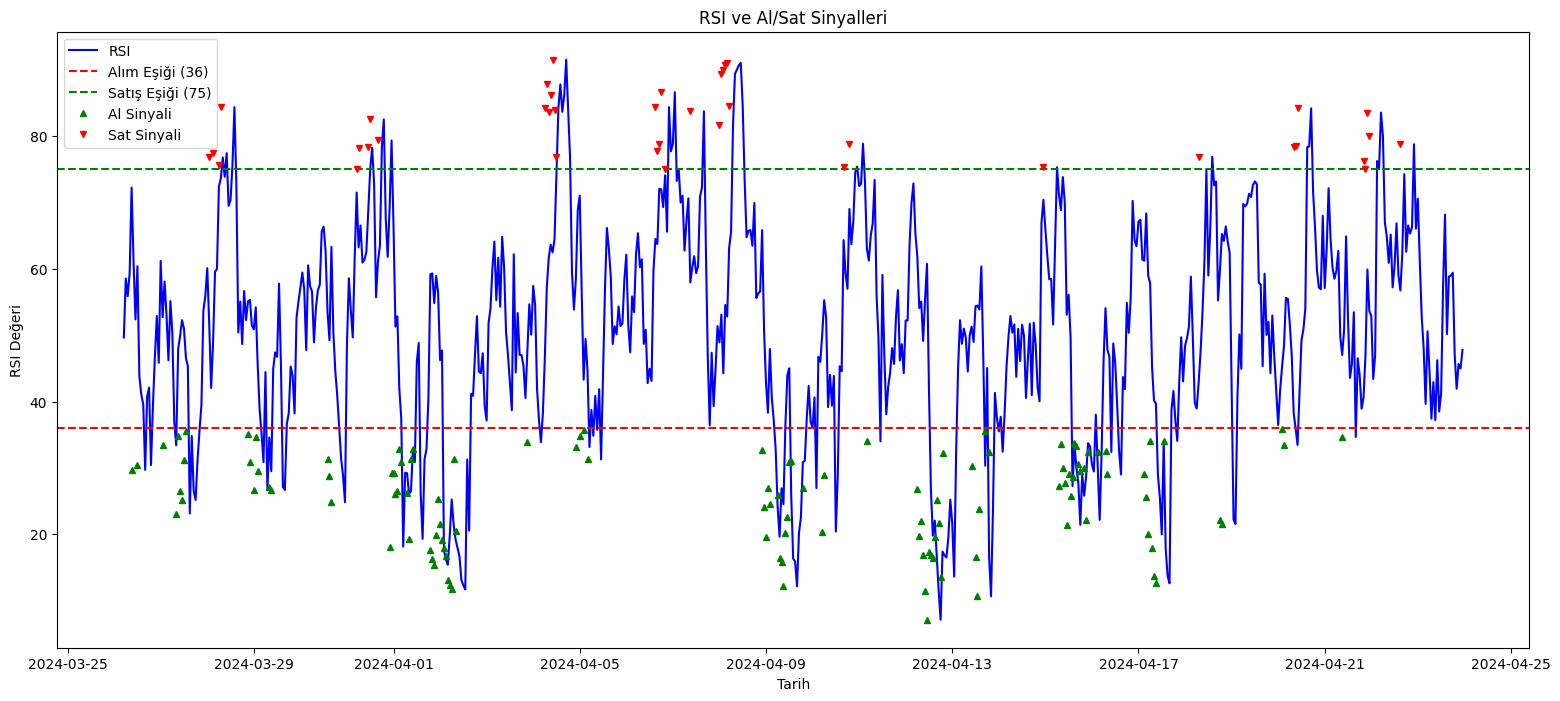

In [6]:
rsi_length = len(rsi_values)
data_length = len(data)

plt.figure(figsize=(19, 8))
plt.plot(data.index[-rsi_length:], rsi_values, label='RSI', color='blue')

plt.axhline(y=36, color='r', linestyle='--', label='Alım Eşiği (36)')
plt.axhline(y=75, color='g', linestyle='--', label='Satış Eşiği (75)')

plt.plot(data.index[buy_indices[-rsi_length:]], rsi_values[buy_indices[-rsi_length:]], '^', markersize=5, color='green', label='Al Sinyali')
plt.plot(data.index[sell_indices[-rsi_length:]], rsi_values[sell_indices[-rsi_length:]], 'v', markersize=5, color='red', label='Sat Sinyali')

plt.title('RSI ve Al/Sat Sinyalleri')
plt.xlabel('Tarih')
plt.ylabel('RSI Değeri')
plt.legend()
plt.show()

# Fiyat'ta Doğru al-sat önerilerini gösterme

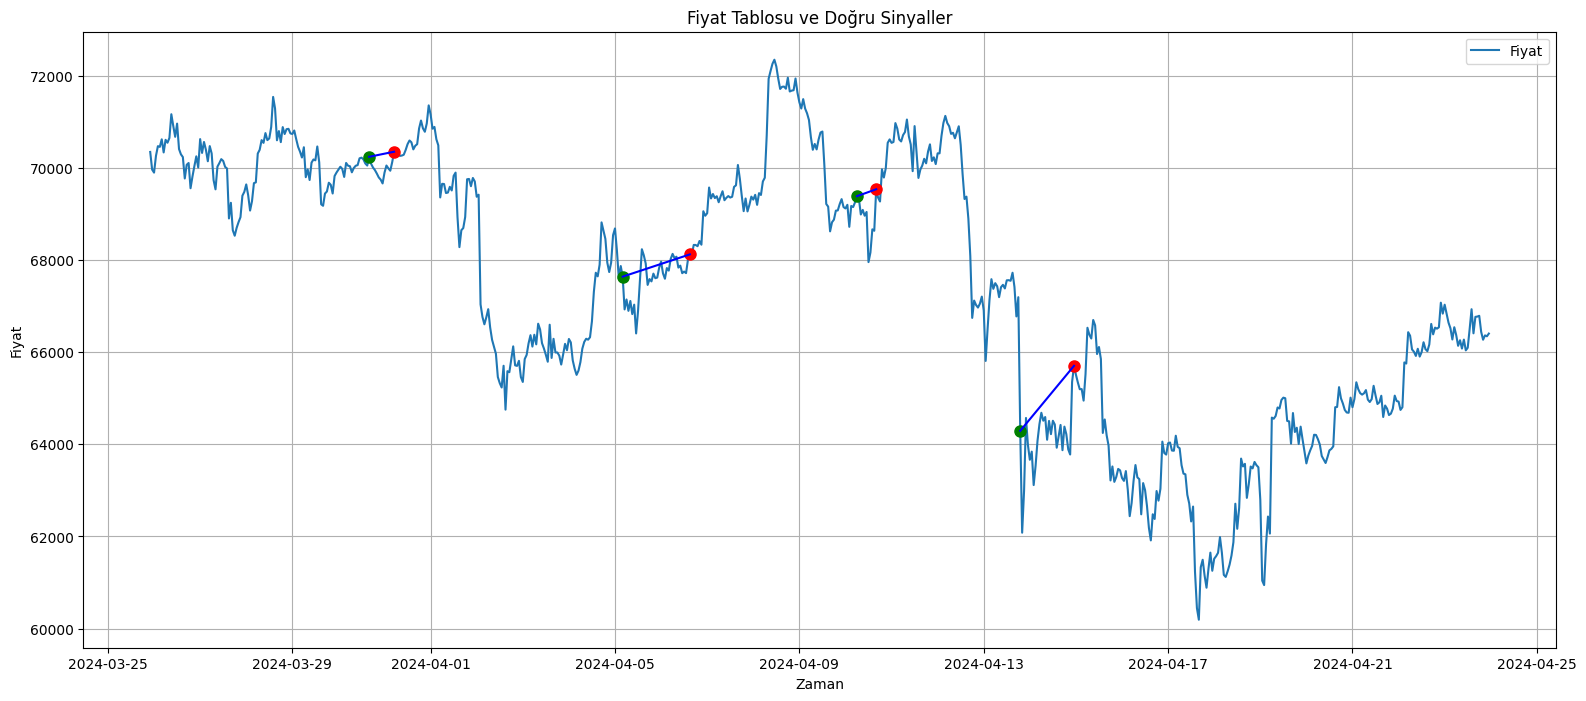

In [7]:
def plot_correct_signals(data, signals, buy_indices, sell_indices):
    signals = np.sort(np.concatenate((buy_indices, sell_indices)))
    correct_signals = []

    for i in range(len(signals) - 1):
        # Eğer mevcut sinyal bir alım sinyaliyse
        if signals[i] in buy_indices:
            # Sonraki sinyal bir satım sinyaliyse ve fiyat yükselmişse
            if signals[i+1] in sell_indices and data['Close'].values[signals[i+1]] > data['Close'].values[signals[i]]:
                correct_signals.append((signals[i], signals[i+1]))
        # Eğer mevcut sinyal bir satım sinyaliyse
        elif signals[i] in sell_indices:
            # Sonraki sinyal bir alım sinyaliyse ve fiyat düşmüşse
            if signals[i+1] in buy_indices and data['Close'].values[signals[i+1]] < data['Close'].values[signals[i]]:
                correct_signals.append((signals[i], signals[i+1]))

    plt.figure(figsize=(19, 8))
    plt.plot(data.index, data['Close'], label='Fiyat')

    for entry, exit in correct_signals:
        plt.plot(data.index[entry], data['Close'].values[entry], 'go' if entry in buy_indices else 'ro', markersize=8)
        plt.plot(data.index[exit], data['Close'].values[exit], 'go' if exit in buy_indices else 'ro', markersize=8)
        plt.plot([data.index[entry], data.index[exit]], [data['Close'].values[entry], data['Close'].values[exit]], 'b-')

    plt.title('Fiyat Tablosu ve Doğru Sinyaller')
    plt.xlabel('Zaman')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_correct_signals(data, signals, buy_indices, sell_indices)


# Binanceden veri çekme

In [22]:
#Verileri getirme
API_Key = "QkGSZFlPppl7a5xc9qyUs8AGBr0gFLDc2XsWlGacTL73SoHf4UHZbk7gTZLNuj9p"
Secret_Key = "gQmP0g7cnzYniHNZjZeIyX5uerTs13wBi16eGyjViFvntDgzjU7LqVOtKs7y7x1P"
client = Client(API_Key,Secret_Key,tld='us')


# Binance verilerin mumlarını alma

In [34]:
def verileriGetir(sembol, periyot, baslangic, bitis):
  mumlar = client.get_historical_klines(sembol, periyot, baslangic, bitis)
  return mumlar

# Veritabanı oluşturma

In [35]:
#Csv dosyasına kaydetme
def csvOlustur(sembol, mumlar):
  csvDosya = builtins.open(sembol + ".csv", "w", newline='')
  yazici = csv.writer(csvDosya, delimiter=',')
  for mumVerileri in mumlar:
    yazici.writerow(mumVerileri)
  csvDosya.close()

# Girilen sembollerin verisini çekme

In [42]:
sembolList = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "DOGEUSDT","ATOMUSDT"]
def veriCekmeVeCsvOlusturma(sembolList):
    for coin in sembolList:
        csvOlustur(coin, verileriGetir(coin, Client.KLINE_INTERVAL_1DAY, "19 March 2020", "19 April 2024"))
        print(coin, "csv dosyası oluşturuldu")

# Verilerin Başlığını yazma

In [26]:
okunacakCsv = "BTCUSDT.csv"
basliklar = ['Open_time','Open','High','Low','Close','Volume','Close_time','Quote_asset_volume','Number_of_trades','Taker_buy_base_asset_volume','Taker_buy_quote_asset_volume','Ignore']
df = pd.read_csv(okunacakCsv,names=basliklar)
acilis=df['Open']
print(acilis)

0       42278.79
1       42488.89
2       42600.36
3       42589.35
4       42338.81
          ...   
2708    66584.22
2709    66539.35
2710    66553.72
2711    67059.22
2712    66867.85
Name: Open, Length: 2713, dtype: float64


#TimeStamp Verisini Okunur Hâle Getirme

In [ ]:
def zamanHesapla(timestamp):
    return datetime.fromtimestamp(timestamp / 1000) # milisaniye cinsini kaldırma

def zamanYazdır():
    aciliszamani = df['Open_time']
    for zaman in aciliszamani:
        print(zamanHesapla(zaman))

zamanYazdır()

#Rsi hesaplama ve değişken tanımlama

In [32]:
open = df['Open']
close = df['Close']
acilis_zamani = df['Open_time']
high = df['High']
low = df['Low']
periyod = 14 #default rsı değeri
rsi = ta.rsi(close,periyod)
print(rsi)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2708    64.255400
2709    64.719831
2710    71.172051
2711    65.792201
2712    67.919433
Name: RSI_14, Length: 2713, dtype: float64


#Hareketli Ortlamalar (ma, adx)

In [30]:
ho = ta.ma("sma",close,length=50) #basit
print(ho)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
2708    65356.7728
2709    65389.7902
2710    65436.0732
2711    65479.1356
2712    65525.8340
Name: SMA_50, Length: 2713, dtype: float64


In [31]:
adx = ta.adx(high,low,close,length=14)
print(adx)

         ADX_14     DMP_14     DMN_14
0           NaN        NaN        NaN
1           NaN        NaN        NaN
2           NaN        NaN        NaN
3           NaN        NaN        NaN
4           NaN        NaN        NaN
...         ...        ...        ...
2708  32.723305  32.865166  14.512045
2709  33.007741  31.911573  14.775056
2710  34.159724  38.481815  13.124696
2711  35.254959  36.361773  12.285012
2712  35.953476  34.466070  13.062128

[2713 rows x 3 columns]


#Macd Hesaplama

In [36]:
macd = ta.macd(close,12,26,9)
print(macd)


      MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9
0              NaN            NaN            NaN
1              NaN            NaN            NaN
2              NaN            NaN            NaN
3              NaN            NaN            NaN
4              NaN            NaN            NaN
...            ...            ...            ...
2708    359.157613      27.155256     332.002356
2709    359.394981      21.914100     337.480881
2710    395.896224      46.732275     349.163950
2711    403.204763      43.232651     359.972112
2712    418.002453      46.424272     371.578180

[2713 rows x 3 columns]


#Boolinger Bandi hesaplama


In [37]:
bb = ta.bbands(close,20,2)
print(bb)

        BBL_20_2.0  BBM_20_2.0    BBU_20_2.0  BBB_20_2.0  BBP_20_2.0
0              NaN         NaN           NaN         NaN         NaN
1              NaN         NaN           NaN         NaN         NaN
2              NaN         NaN           NaN         NaN         NaN
3              NaN         NaN           NaN         NaN         NaN
4              NaN         NaN           NaN         NaN         NaN
...            ...         ...           ...         ...         ...
2708  65039.593275  65996.8875  66954.181725    2.901028    0.774306
2709  65299.001393  66088.1975  66877.393607    2.388312    0.794947
2710  65544.170954  66200.9855  66857.800046    1.984304    1.154168
2711  65564.499389  66253.0355  66941.571611    2.078504    0.933503
2712  65593.883015  66317.1065  67040.329985    2.181107    0.986857

[2713 rows x 5 columns]



#Golden ve Dead Cross ile al sat (SMA50-SMA200)

In [43]:
def DCA ():
  cuzdan = 100
  alimSayisi = 0
  satimSayisi = 0
  toplamCoin = 0
  komisyonOrani = 75/10000
  verilenKomisyon = 0
  sma50 = ta.ma("sma",close,length=50)
  sma200 = ta.ma("sma",close,length=200)

  print("############################")
  for i in range(len(close)):
    if pd.isna(sma50[i]) is False:

      if sma50[i-1] < sma200[i-1] and sma50 [i] > sma200[i]: # yukarı kesim
        print(zamanHesapla(acilis_zamani[i+1])," tarihinde ", cuzdan/close[i], " adet BTC alindi")
        alimSayisi+=1
        toplamCoin=cuzdan/close[i]
        verilenKomisyon+=komisyonOrani*cuzdan

      # aşağı kesim
      if sma50[i-1] > sma200[i-1] and sma50[i] < sma200[i] and alimSayisi > 0 :
        print(zamanHesapla(acilis_zamani[i+1])," tarihinde ", toplamCoin, " adet BTC satildi")

        satimSayisi+=1
        fiyat = close[i] * toplamCoin
        cuzdan = fiyat
        toplamCoin = 0
        verilenKomisyon+=komisyonOrani*fiyat
        print (f"Bu iki işlem sonucunda işlem ederi : {cuzdan}")
        print("#####################################")

  print(f"Toplam yapılan islem : {(alimSayisi+satimSayisi)/2}")
  print(f"Toplam verilen komisyon : {verilenKomisyon}")
  print(f"Total cuzdan : {cuzdan}")

DCA()

############################
2024-01-27 10:00:00  tarihinde  0.002400730974567136  adet BTC alindi
2024-02-06 00:00:00  tarihinde  0.002400730974567136  adet BTC satildi
Bu iki işlem sonucunda işlem ederi : 102.5140454765667
#####################################
2024-02-07 19:00:00  tarihinde  0.0023484618188204156  adet BTC alindi
2024-02-22 04:00:00  tarihinde  0.0023484618188204156  adet BTC satildi
Bu iki işlem sonucunda işlem ederi : 121.14277264661405
#####################################
2024-02-26 17:00:00  tarihinde  0.0022728901601646195  adet BTC alindi
2024-03-16 06:00:00  tarihinde  0.0022728901601646195  adet BTC satildi
Bu iki işlem sonucunda işlem ederi : 156.78171308689687
#####################################
2024-03-25 13:00:00  tarihinde  0.0023388229945482788  adet BTC alindi
2024-04-02 07:00:00  tarihinde  0.0023388229945482788  adet BTC satildi
Bu iki işlem sonucunda işlem ederi : 156.62554987555086
#####################################
2024-04-07 12:00:00  tarih

# Hareketli ortlamaya göre en iyi EMAD ve en kazançlı kriptoyu bulma

In [47]:
symbolList = []
info = client.get_all_tickers()
for x in info:
    if 'USDT' in x['symbol']:
        if 'DOWN' in x['symbol'] or 'UP' in x['symbol']:
            pass
        else:
            symbolList.append(x['symbol'])

In [45]:
def DCA(sembol, periyot1 , periyot2):
    islemBasiDolar = 50
    alimSayisi = 0
    toplamBTC = 0
    komisyonOrani = 75/10000
    komisyon = 0

    csvName= sembol + '.csv'
    attributes = ["Open_time",'Open','High','Low','Close','Volume','1','2','3','4','5','6']
    df = pd.read_csv(csvName, names=attributes)
    kapanis = df['Close']

    emaD = ta.ema(df['Close'], length=periyot1) #kısa EMA
    emaU = ta.ema(df['Close'], length=periyot2) #Uzun EMA

    #print("############################")
    #print("EMA :", periyot)

    for i in range(df.shape[0]):
        if pd.isna(emaD[i]) is False and len(df)>100:
            if emaU[i - 1] < emaD[i - 1] and emaU [i - 0] > emaD[i - 0]: # yukarı kesim
                alimSayisi += 1
                toplamBTC += islemBasiDolar/kapanis[i]
                komisyon += komisyonOrani*islemBasiDolar

    '''print(f"Toplam yapılan işlem: {alimSayisi}")
    print(f"Toplam alınan {sembol}: {toplamBTC}")
    print(f"Toplam yatırım: {islemBasiDolar*alimSayisi}")
    print(f"Şuanki cüzdan tutarı: {toplamBTC*kapanis[len(kapanis) - 1]}")'''

    try:
        kat = (np.round(toplamBTC,4) * kapanis[len(kapanis)-1]- komisyon) / (islemBasiDolar * alimSayisi)
    except:
        print(f"{sembol}'de hata var")

    kazanc = toplamBTC * kapanis[len(kapanis) - 1] - (islemBasiDolar * alimSayisi) - komisyon

    '''print("Kaça katladı: ", kat)
    print("Toplam kazanc: ", kazanc)
    print("Toplam verilen komisyon: ", komisyon)
    print("---------------------------------------------------------------------------------")'''
    return [kat , periyot1 , periyot2]
veriCekmeVeCsvOlusturma(['BTCUSDT','ETHUSDT','FILUSDT','ALICEUSDT','SOLUSDT','BNBUSDT'])
DCA("BTCUSDT",2,50)

BTCUSDT csv dosyası oluşturuldu
ETHUSDT csv dosyası oluşturuldu
FILUSDT csv dosyası oluşturuldu
ALICEUSDT csv dosyası oluşturuldu
SOLUSDT csv dosyası oluşturuldu
BNBUSDT csv dosyası oluşturuldu


[3.153714138787879, 2, 50]

#Kod optimizasyonu (En iyi keşim noktaları, En çok karli crypto , En iyi EMA)

In [50]:
def optimize(sembolList):
  oranlar=[]
  dcalar = []
  totaloranlar=[]
  #emaList=[]
  uzunEmalar=[]
  kisaEmalar=[]
  ema_kesimler = []

  for i in sembolList:
    for x in range(2, 21):
      for y in range(50, 61):
        dcaFun = DCA(i, x, y)
        oranlar.append(dcaFun[0])
        uzunEmalar.append(dcaFun[1])
        kisaEmalar.append(dcaFun[2])
        ema_kesimler.append((dcaFun[1], dcaFun[2] , format(dcaFun[0], ".3f")))

    totaloranlar.append(max(oranlar))
    print("################################")
    print (f"coin adı : {i}")
    print(f"En iyi kazanç : {max(oranlar)}")
    print(f"En iyi EMA iki kesişim : {uzunEmalar[oranlar.index(max(oranlar))]} , {kisaEmalar[oranlar.index(max(oranlar))]}")

    #print(f"en_iyi_kazanc EMA : {oranlar.index(max(oranlar))+2}" )
    #emaList.append(oranlar.index(max(oranlar))+2)
    print("################################")
    oranlar.clear()

  print(f"Maximum kazanç : {max(totaloranlar)}")
  enCokKazandıranCoin = sembolList[totaloranlar.index(max(totaloranlar))]
  print(f"Maximum kazancı veren coin : {enCokKazandıranCoin}")
  kesisim_kaydet(ema_kesimler)


import pandas as pd

def kesisim_kaydet(ema_kesimler):
    df = pd.DataFrame(ema_kesimler, columns=['EMA1', 'EMA2' ,'EMA3'])
    df.to_csv('ema_kesimler.csv', index=False)
    print("EMA kesişim verileri başarıyla 'ema_kesimler.csv' dosyasına kaydedildi.")

optimize(['BTCUSDT'])

################################
coin adı : BTCUSDT
En iyi kazanç : 3.153714138787879
En iyi EMA iki kesişim : 2 , 50
################################
Maximum kazanç : 3.153714138787879
Maximum kazancı veren coin : BTCUSDT
EMA kesişim verileri başarıyla 'ema_kesimler.csv' dosyasına kaydedildi.


# Kesişim verilerin okunması

In [48]:
veri = pd.read_csv('ema_kesimler.csv')

dugumler = []
baglantilar = []

# Gelen veri adedince düğüm oluşturulması ve javascripti html ye gömme

In [ ]:
import json
import webbrowser
import pandas as pd
from jinja2 import Template

veri = pd.read_csv('ema_kesimler.csv')

dugumler = []
baglantilar = []

for i, row in veri.iterrows():
    for j, ema_sutunu in enumerate(['EMA1', 'EMA2', 'EMA3']):
        if j == 0:
            radius = min(15, row[ema_sutunu])
        elif j == 1:
            radius = min(15, row[ema_sutunu])
        else:
            radius = min(15, (row[ema_sutunu] - row['EMA1']) + (row['EMA2'] - row[ema_sutunu]))
        radius_str = "{:.2f}".format(radius)
        radius = float(radius_str)
        dugum = {'id': 'Düğüm ' + str(i * 3 + j + 1), 'group': 'Group', 'radius': radius, 'citing_patents_count': row[ema_sutunu]}
        dugumler.append(dugum)

        if j > 0:
            fark = abs(row[ema_sutunu] - row[veri.columns[j - 1]])
            baglanti = {'source': 'Düğüm ' + str(i * 3 + j), 'target': 'Düğüm ' + str(i * 3 + j + 1), 'value': fark / 10}
            baglantilar.append(baglanti)

with open("index.html") as file:
    html_template = Template(file.read())

# Jinja2 şablon motoru ile veri ve bağlantıları HTML dosyasına gönder
html_content = html_template.render(nodes=json.dumps(dugumler), links=json.dumps(baglantilar))

# HTML içeriğini dosyaya yaz
with open("graph.html", "w") as file:
    file.write(html_content)

webbrowser.open("graph.html")


# html sayfası

In [ ]:
<!-- index.html -->
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>D3.js Graph</title>
  <script src="https://d3js.org/d3.v7.min.js"></script>
  <style>
    svg {
      max-width: 100%;
      height: 100%;
      background-color: black;
    }
    text {
      fill: white;
    }
  </style>
</head>
<body>
  <script>
    const data = {
      nodes: {{ nodes | safe }},
      links: {{ links | safe }}
    };

    async function loadData() {
      const width = window.innerWidth;
      const height = window.innerHeight;
      const color = d3.scaleOrdinal(d3.schemeCategory10);
      const links = data.links.map(function(d) { return Object.assign({}, d); });
      const nodes = data.nodes.map(function(d) { return Object.assign({}, d); });

      const simulation = d3.forceSimulation(nodes)
        .force("link", d3.forceLink(links).id(function(d) { return d.id; }))
        .force("charge", d3.forceManyBody())
        .force("x", d3.forceX())
        .force("y", d3.forceY());

      const svg = d3.create("svg")
        .attr("width", width)
        .attr("height", height)
        .attr("viewBox", [-width / 2, -height / 2, width, height]);

      const link = svg.append("g")
        .attr("stroke", "#f00")
        .attr("stroke-opacity", 0.6)
        .selectAll("line")
        .data(links)
        .join("line")
        .attr("stroke-width", function(d) { return Math.sqrt(d.value); });

      const node = svg.append("g")
        .attr("stroke", "#fff")
        .attr("stroke-width", 1.5)
        .selectAll("g")
        .data(nodes)
        .join("g")
        .attr("transform", d => `translate(${d.x},${d.y})`);

      node.append("circle")
        .attr("r", d => d.radius * 1)
        .attr("fill", "black");

      node.append("text")
        .attr("text-anchor", "middle")
        .attr("dominant-baseline", "middle")
        .attr("font-size", "10px")
        .attr("fill", d => d.group === 'Group' ? 'red' : 'white')
        .text(d => d.citing_patents_count);

      node.call(d3.drag()
        .on("start", dragstarted)
        .on("drag", dragged)
        .on("end", dragended));

      simulation.on("tick", function() {
        link
          .attr("x1", function(d) { return d.source.x; })
          .attr("y1", function(d) { return d.source.y; })
          .attr("x2", function(d) { return d.target.x; })
          .attr("y2", function(d) { return d.target.y; });

        node
          .attr("transform", function(d) { return `translate(${d.x},${d.y})`; });
      });

      function dragstarted(event) {
        if (!event.active) simulation.alphaTarget(0.3).restart();
        event.subject.fx = event.subject.x;
        event.subject.fy = event.subject.y;
      }

      function dragged(event) {
        event.subject.fx = event.x;
        event.subject.fy = event.y;
      }

      function dragended(event) {
        if (!event.active) simulation.alphaTarget(0);
        event.subject.fx = null;
        event.subject.fy = null;
      }

      document.body.appendChild(svg.node());
    }

    window.onload = loadData;
  </script>
</body>
</html>
